In [1]:
import pandas as pd
import gc

pd.set_option('display.float_format', '{:.10f}'.format)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# load

In [3]:
train = pd.read_csv('./data/train.csv')
historical_transactions = pd.read_csv('./data/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('./data/new_merchant_transactions.csv')

In [4]:
all_transactions = pd.concat([historical_transactions, new_merchant_transactions], axis=0)

In [5]:
all_transactions.nunique()

authorized_flag                2
card_id                   325540
city_id                      308
category_1                     2
installments                  15
category_3                     3
merchant_category_id         331
merchant_id               334633
month_lag                     16
purchase_amount           221246
purchase_date           17717516
category_2                     5
state_id                      25
subsector_id                  41
dtype: int64

# m_count & c_count

In [6]:
c_m = all_transactions[["card_id", "merchant_id"]].drop_duplicates(["card_id", "merchant_id"])

In [7]:
train[train.target == 0].shape

(1630, 6)

In [8]:
m_count = c_m.groupby("card_id").size()
c_count = c_m.groupby("merchant_id").size()

In [9]:
(c_count < 2).sum()

39627

In [10]:
(m_count < 2).sum()

1696

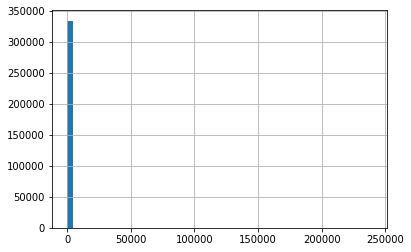

In [11]:
c_count.hist(bins=50)

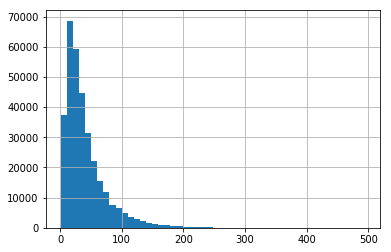

In [12]:
m_count.hist(bins=50)

In [13]:
train["m_count"] = train.card_id.map(m_count)

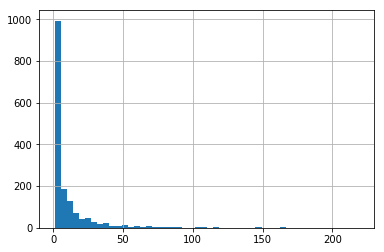

In [14]:
train[train.target == 0].m_count.hist(bins=50)

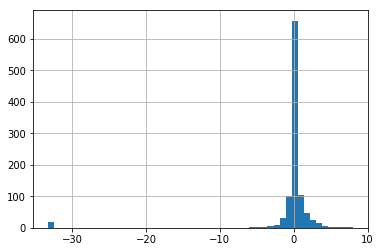

In [15]:
train[train.m_count == 1].target.hist(bins=50)

In [16]:
print((train.target == 0).sum())
print((train.m_count == 1).sum())
print(((train.target == 0) & (train.m_count == 1)).sum())

1630
1035
456


# post-process

In [17]:
from data_io import load_submission

submission = load_submission("blend029p")
submission.loc[submission.card_id.isin(m_count[m_count == 1].index), "target"] = 0
submission.to_csv("./data/submissions/blend029p-post.csv", index=False)

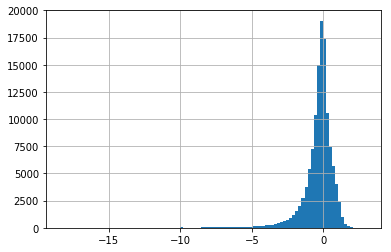

In [18]:
submission.target.hist(bins=100)

# special-merchant-ids

In [19]:
train["outlier"] = (train.target < -30).astype(int)
train["zero"] = (train.target == 0).astype(int)

In [20]:
c_m["c_count"] = c_m.merchant_id.map(c_count)
c_m["m_count"] = c_m.card_id.map(m_count)
c_m["zero"] = c_m.card_id.map(train.set_index("card_id").zero)
c_m["outlier"] = c_m.card_id.map(train.set_index("card_id").outlier)
c_m["is_train"] = 0
c_m.loc[c_m.card_id.isin(train.card_id), "is_train"] = 1

In [21]:
c_m.head()

,card_id,merchant_id,c_count,m_count,zero,outlier,is_train
0,C_ID_4e6213e9bc,M_ID_e020e9b302,5422.0000000000,58,nan,nan,0
1,C_ID_4e6213e9bc,M_ID_86ec983688,5980.0000000000,58,nan,nan,0
2,C_ID_4e6213e9bc,M_ID_979ed661fc,402.0000000000,58,nan,nan,0
3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,60.0000000000,58,nan,nan,0
5,C_ID_4e6213e9bc,M_ID_50af771f8d,1023.0000000000,58,nan,nan,0


In [22]:
pd.set_option('display.float_format', '{:.0f}'.format)
c_m[(c_m.zero==1) & (c_m.m_count == 1)].head()

,card_id,merchant_id,c_count,m_count,zero,outlier,is_train
2077431,C_ID_49f0655e15,M_ID_b574941e3a,867,1,1,0,1
4163811,C_ID_ba26c0f556,M_ID_fc7d7969c3,30827,1,1,0,1
4900251,C_ID_ee05c2b113,M_ID_fc7d7969c3,30827,1,1,0,1
6397377,C_ID_01d30a308d,M_ID_1fe05656cb,351,1,1,0,1
8154940,C_ID_89c23b109c,M_ID_00a6ca8a8a,239115,1,1,0,1


In [23]:
part = c_m[(c_m.m_count == 1) & (c_m.is_train == 1)]


## find-zero

select by m_count only
1 zero.prob 0.4405797101449275 1035 / 1696
2 zero.prob 0.23326359832635984 1912 / 3060
3 zero.prob 0.11959521619135234 3261 / 5364
4 zero.prob 0.06559571619812583 5976 / 9680
5 zero.prob 0.04118773946360153 10440 / 16760

select by m_count & merchant_id
merchant_ids: 36 / 222


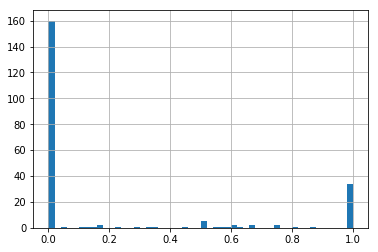

1 zero.prob 0.9384615384615385 65 / 100
2 zero.prob 0.5185185185185185 81 / 118
3 zero.prob 0.34285714285714286 70 / 114
4 zero.prob 0.21212121212121213 66 / 115
5 zero.prob 0.12371134020618557 97 / 152

select by merchant_id only
merchant_ids: 128 / 313541


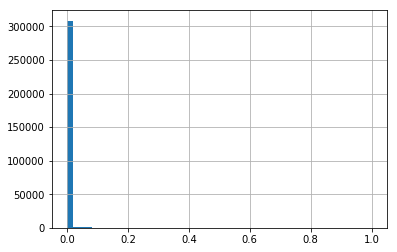

5 zero.prob 1.0 129 / 211


In [24]:
col = "zero"

print("select by m_count only")
for i in range(5):
    th = i + 1
    part = c_m[(c_m.m_count == th) & (c_m.is_train == 1)]
    a = part[col].mean()
    b = part.shape[0]
    c = c_m[(c_m.m_count == th)].shape[0]
    print(th, col + ".prob", a, b, "/", c)

print("")
print("select by m_count & merchant_id")
part = c_m[(c_m.m_count == 1) & (c_m.is_train == 1)]
candidates = part.groupby("merchant_id")[col].mean().sort_values()
print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
candidates.hist(bins=50)
plt.show()

for i in range(5):
    th = i + 1
    part = c_m[(c_m.m_count == th) & (c_m.is_train == 1)]
    a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
    b = part[part.merchant_id.isin(candidates[candidates > .8].index)].shape[0]
    c = c_m[(c_m.m_count == th) & c_m.merchant_id.isin(candidates[candidates > .8].index)].shape[0]
    print(th, col + ".prob", a, b, "/", c)
    
print("")
print("select by merchant_id only")
part = c_m[(c_m.is_train == 1)]
candidates = part.groupby("merchant_id")[col].mean().sort_values()
print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
candidates.hist(bins=50)
plt.show()

a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
b = part[part.merchant_id.isin(candidates[candidates > .8].index)].shape[0]
c = c_m[c_m.merchant_id.isin(candidates[candidates > .8].index)].shape[0]

print(th, col + ".prob", a, b, "/", c)

## find-outlier

select by m_count only
1 outlier.prob 0.01642512077294686 1035 / 1696
2 outlier.prob 0.014644351464435146 1912 / 3060
3 outlier.prob 0.011039558417663294 3261 / 5364
4 outlier.prob 0.013386880856760375 5976 / 9680
5 outlier.prob 0.011973180076628353 10440 / 16760

select by m_count & merchant_id
merchant_ids: 3 / 222


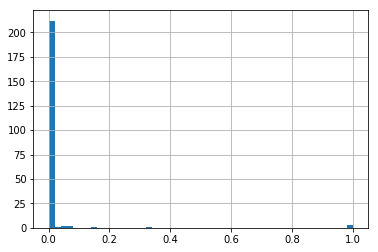

1 outlier.prob 1.0 3 / 4
2 outlier.prob 0.0 2 / 2
3 outlier.prob 0.0 2 / 3
4 outlier.prob 0.0 1 / 3
5 outlier.prob 0.14285714285714285 7 / 12

select by merchant_id only
merchant_ids: 478 / 313541


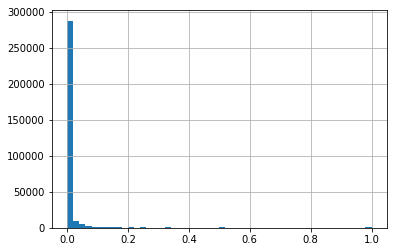

5 outlier.prob 1.0 480 / 865


In [25]:
col = "outlier"

print("select by m_count only")
for i in range(5):
    th = i + 1
    part = c_m[(c_m.m_count == th) & (c_m.is_train == 1)]
    a = part[col].mean()
    b = part.shape[0]
    c = c_m[(c_m.m_count == th)].shape[0]
    print(th, col + ".prob", a, b, "/", c)

print("")
print("select by m_count & merchant_id")
part = c_m[(c_m.m_count == 1) & (c_m.is_train == 1)]
candidates = part.groupby("merchant_id")[col].mean().sort_values()
print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
candidates.hist(bins=50)
plt.show()

for i in range(5):
    th = i + 1
    part = c_m[(c_m.m_count == th) & (c_m.is_train == 1)]
    a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
    b = part[part.merchant_id.isin(candidates[candidates > .8].index)].shape[0]
    c = c_m[(c_m.m_count == th) & c_m.merchant_id.isin(candidates[candidates > .8].index)].shape[0]
    print(th, col + ".prob", a, b, "/", c)
    
print("")
print("select by merchant_id only")
part = c_m[(c_m.is_train == 1)]
candidates = part.groupby("merchant_id")[col].mean().sort_values()
print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
candidates.hist(bins=50)
plt.show()

a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
b = part[part.merchant_id.isin(candidates[candidates > .8].index)].shape[0]
c = c_m[c_m.merchant_id.isin(candidates[candidates > .8].index)].shape[0]

print(th, col + ".prob", a, b, "/", c)

# special-merchant-features

1. zero_with_count_1 ~ 5
2. zero_merchant_only
3. outlier_merchant_only

In [26]:
from data_io import load_train, load_test

In [27]:
train_test = pd.concat([load_train(), load_test()])
train_test.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,target
0,C_ID_92a2005557,5,2,1,2017-06,-1
1,C_ID_3d0044924f,4,1,0,2017-01,0
2,C_ID_d639edf6cd,2,2,0,2016-08,1
3,C_ID_186d6a6901,4,3,0,2017-09,0
4,C_ID_cdbd2c0db2,1,3,0,2017-11,-0


In [28]:
train_test = train_test[["card_id", "target"]]


select by merchant_id only
merchant_ids: 128 / 313541


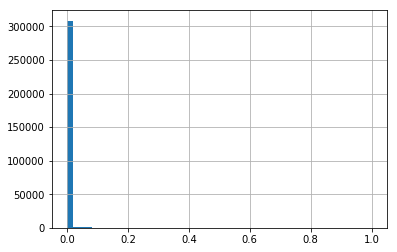

5 zero.prob 1.0 99 / 180


In [29]:
col = "zero"

print("")
print("select by merchant_id only")
part = c_m[(c_m.is_train == 1)]
candidates = part.groupby("merchant_id")[col].mean().sort_values()
print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
candidates.hist(bins=50)
plt.show()

a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
c = c_m[c_m.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()

print(th, col + ".prob", a, b, "/", c)

In [30]:
train_test = pd.concat([load_train(), load_test()])
train_test = train_test[["card_id", "target"]]

col = "zero"

print("select {}".format(col))
print("select by m_count & merchant_id")

for i in range(10):
    th = i + 1
    count_cond = (c_m.m_count == th)
    part = c_m[count_cond & (c_m.is_train == 1)]
    candidates = part.groupby("merchant_id")[col].mean().sort_values()
    # print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
    # candidates.hist(bins=50)
    # plt.show()
    a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
    b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
    marked = c_m[count_cond & c_m.merchant_id.isin(candidates[candidates > .8].index)]
    c = marked.card_id.nunique()
    print(th, col + ".prob", a, b, "/", c)
    
    col_name = "{}_with_count{}".format(col, th)
    train_test[col_name] = 0
    train_test.loc[train_test.card_id.isin(marked.card_id.unique()), col_name] = 1
    
    
for l, r in ((10, 15), (15, 20), (20, 30), (30, 50), (50, 100), (100, 99999)):
    count_cond = (c_m.m_count > l) & (c_m.m_count <= r)
    part = c_m[count_cond & (c_m.is_train == 1)]
    candidates = part.groupby("merchant_id")[col].mean().sort_values()
    # print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
    # candidates.hist(bins=50)
    # plt.show()
    a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
    b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
    marked = c_m[count_cond & c_m.merchant_id.isin(candidates[candidates > .8].index)]
    c = marked.card_id.nunique()
    print(l, r, col + ".prob", a, b, "/", c)
    
    col_name = "{}_with_count{}to{}".format(col, l, r)
    train_test[col_name] = 0
    train_test.loc[train_test.card_id.isin(marked.card_id.unique()), col_name] = 1

print("")
print("select by merchant_id only")
part = c_m[(c_m.is_train == 1)]
candidates = part.groupby("merchant_id")[col].mean().sort_values()
# print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
# candidates.hist(bins=50)
# plt.show()

a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
marked = c_m[c_m.merchant_id.isin(candidates[candidates > .8].index)]
c = marked.card_id.nunique()

print(th, col + ".prob", a, b, "/", c)
col_name = "{}_merchant_only".format(col)
train_test[col_name] = 0
train_test.loc[train_test.card_id.isin(marked.card_id.unique()), col_name] = 1

select zero
select by m_count & merchant_id
1 zero.prob 0.9384615384615385 65 / 100
2 zero.prob 0.9910714285714286 101 / 128
3 zero.prob 1.0 68 / 85
4 zero.prob 1.0 70 / 88
5 zero.prob 1.0 72 / 97
6 zero.prob 1.0 39 / 50
7 zero.prob 1.0 48 / 65
8 zero.prob 1.0 45 / 58
9 zero.prob 1.0 38 / 60
10 zero.prob 1.0 28 / 39
10 15 zero.prob 1.0 108 / 208
15 20 zero.prob 1.0 73 / 152
20 30 zero.prob 1.0 66 / 165
30 50 zero.prob 1.0 51 / 124
50 100 zero.prob 1.0 40 / 88
100 99999 zero.prob 1.0 13 / 45

select by merchant_id only
10 zero.prob 1.0 99 / 180


In [31]:
def mark_rules(train_test, col, confidence=10):
    global c_m
    print("select {}".format(col))
    print("select by m_count & merchant_id")

    c_m = c_m[c_m.c_count > confidence]
    
    for i in range(2):
        th = i + 1
        count_cond = (c_m.m_count == th)
        part = c_m[count_cond & (c_m.is_train == 1)]
        candidates = part.groupby("merchant_id")[col].mean().sort_values()
        # print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
        # candidates.hist(bins=50)
        # plt.show()
        a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
        b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
        marked = c_m[count_cond & c_m.merchant_id.isin(candidates[candidates > .8].index)]
        c = marked.card_id.nunique()
        print(th, col + ".prob", a, b, "/", c)

        col_name = "{}_with_count{}".format(col, th)
        train_test[col_name] = 0
        train_test.loc[train_test.card_id.isin(marked.card_id.unique()), col_name] = 1


    for l, r in ((3, 10), (10, 15), (15, 20), (20, 30)):
        count_cond = (c_m.m_count > l) & (c_m.m_count <= r)
        part = c_m[count_cond & (c_m.is_train == 1)]
        candidates = part.groupby("merchant_id")[col].mean().sort_values()
        # print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
        # candidates.hist(bins=50)
        # plt.show()
        a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
        b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
        marked = c_m[count_cond & c_m.merchant_id.isin(candidates[candidates > .8].index)]
        c = marked.card_id.nunique()
        print(l, r, col + ".prob", a, b, "/", c)

        col_name = "{}_with_count{}to{}".format(col, l, r)
        train_test[col_name] = 0
        train_test.loc[train_test.card_id.isin(marked.card_id.unique()), col_name] = 1

    print("")
    print("select by merchant_id only")
    part = c_m[(c_m.is_train == 1)]
    candidates = part.groupby("merchant_id")[col].mean().sort_values()
    # print("merchant_ids:", (candidates > .8).sum(), "/", candidates.shape[0])
    # candidates.hist(bins=50)
    # plt.show()

    a = part[part.merchant_id.isin(candidates[candidates > .8].index)][col].mean()
    b = part[part.merchant_id.isin(candidates[candidates > .8].index)].card_id.nunique()
    marked = c_m[c_m.merchant_id.isin(candidates[candidates > .8].index)]
    c = marked.card_id.nunique()

    print(th, col + ".prob", a, b, "/", c)
    col_name = "{}_merchant_only".format(col)
    train_test[col_name] = 0
    train_test.loc[train_test.card_id.isin(marked.card_id.unique()), col_name] = 1
    return train_test

In [32]:
train_test = pd.concat([load_train(), load_test()])
train_test = train_test[["card_id", "target"]]
train_test = mark_rules(train_test, "zero", 50)
train_test = mark_rules(train_test, "outlier", 50)

select zero
select by m_count & merchant_id
1 zero.prob 0.9298245614035088 57 / 92
2 zero.prob 0.9861111111111112 68 / 95
3 10 zero.prob 1.0 124 / 192
10 15 zero.prob 1.0 52 / 107
15 20 zero.prob 1.0 36 / 85
20 30 zero.prob 1.0 12 / 27

select by merchant_id only
2 zero.prob nan 0 / 0
select outlier
select by m_count & merchant_id
1 outlier.prob 1.0 2 / 3
2 outlier.prob 1.0 3 / 3
3 10 outlier.prob 1.0 89 / 157
10 15 outlier.prob 1.0 84 / 190
15 20 outlier.prob 1.0 66 / 167
20 30 outlier.prob 1.0 30 / 94

select by merchant_id only
2 outlier.prob nan 0 / 0


In [33]:
m_count.shape

(325540,)

In [34]:
(c_count > 1000).sum()

1007

In [35]:
((c_count < 1000) & (c_count > 100)).sum()

19402

In [36]:
(m_count < 10).sum()

31138

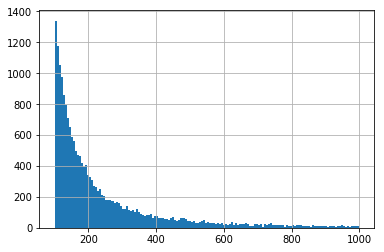

In [37]:
c_count[(c_count < 1000) & (c_count > 100)].hist(bins=150)

In [38]:
zero_columns = [col for col in train_test.columns if col.startswith("zero")] 
outlier_columns = [col for col in train_test.columns if col.startswith("outlier")] 

In [39]:
print((train_test[train_test.target == 0][zero_columns].sum(axis=1) > 0).sum())
print((train_test[train_test.target.notnull()][zero_columns].sum(axis=1) > 0).sum())
print((train_test[train_test.target.notnull()][zero_columns].sum(axis=1) > 0).sum())
print((train_test[zero_columns].sum(axis=1) > 0).sum())

print((train_test[train_test.target < -30][outlier_columns].sum(axis=1) > 0).sum())
print((train_test[train_test.target.notnull()][outlier_columns].sum(axis=1) > 0).sum())
print((train_test[train_test.target.notnull()][outlier_columns].sum(axis=1) > 0).sum())
print((train_test[outlier_columns].sum(axis=1) > 0).sum())

344
349
349
598
274
274
274
614


In [40]:
train_test["zero_mark"] = (train_test[zero_columns].sum(axis=1) > 0).astype(int)
train_test["outlier_mark"] = (train_test[outlier_columns].sum(axis=1) > 0).astype(int)

In [41]:
from data_io import features_downcast, save_dataframe32

In [42]:
train_test.head().drop("target", axis=1)

,card_id,zero_with_count1,zero_with_count2,zero_with_count3to10,zero_with_count10to15,zero_with_count15to20,zero_with_count20to30,zero_merchant_only,outlier_with_count1,outlier_with_count2,outlier_with_count3to10,outlier_with_count10to15,outlier_with_count15to20,outlier_with_count20to30,outlier_merchant_only,zero_mark,outlier_mark
0,C_ID_92a2005557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C_ID_3d0044924f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,C_ID_d639edf6cd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,C_ID_186d6a6901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,C_ID_cdbd2c0db2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
train_test[zero_columns].sum()

zero_with_count1          92
zero_with_count2          95
zero_with_count3to10     192
zero_with_count10to15    107
zero_with_count15to20     85
zero_with_count20to30     27
zero_merchant_only         0
dtype: int64

In [44]:
train_test[outlier_columns].sum()

outlier_with_count1           3
outlier_with_count2           3
outlier_with_count3to10     157
outlier_with_count10to15    190
outlier_with_count15to20    167
outlier_with_count20to30     94
outlier_merchant_only         0
dtype: int64

In [45]:
save_dataframe32(features_downcast("magic"),
                 train_test.head().drop("target", axis=1),
                 keep=["card_id"])

In [46]:
pd.set_option('display.float_format', '{:.2f}'.format)
train_test.head()

,card_id,target,zero_with_count1,zero_with_count2,zero_with_count3to10,zero_with_count10to15,zero_with_count15to20,zero_with_count20to30,zero_merchant_only,outlier_with_count1,outlier_with_count2,outlier_with_count3to10,outlier_with_count10to15,outlier_with_count15to20,outlier_with_count20to30,outlier_merchant_only,zero_mark,outlier_mark
0,C_ID_92a2005557,-0.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C_ID_3d0044924f,0.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,C_ID_d639edf6cd,0.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,C_ID_186d6a6901,0.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,C_ID_cdbd2c0db2,-0.16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# post-process

In [ ]:
from data_io import load_submission

submission = load_submission("blend029p")
submission.loc[submission.card_id.isin(train_test[train_test.zero_mark == 1].card_id), "target"] = 0
submission.loc[submission.card_id.isin(train_test[train_test.outlier_mark == 1].card_id), "target"] = -33.21928
submission.to_csv("./data/submissions/blend029p-post-retry.csv", index=False)

In [ ]:
submission.target.hist(bins=250)

In [ ]:
train_test[train_test.zero_mark == 1].target.hist(bins=5)

In [ ]:
train_test[train_test.outlier_mark == 1].target.hist(bins=5)

In [ ]:
from data_io import load_submission

submission = load_submission("blend029p")
submission.loc[submission.card_id.isin(train_test[train_test.zero_mark == 1].card_id), "target"] = 0
# submission.loc[submission.card_id.isin(train_test[train_test.outlier_mark == 1].card_id), "target"] = -33.21928
submission.to_csv("./data/submissions/blend029p-post-zero.csv", index=False)

In [ ]:
submission.target.hist(bins=50)

In [ ]:
outlier_columns

In [ ]:
from data_io import load_submission

mark_as_zero = train_test[(train_test.zero_merchant_only == 1) | (train_test.zero_with_count1 == 1)].card_id
mark_as_outlier = train_test[(train_test.outlier_merchant_only == 1) | (train_test.outlier_with_count1 == 1)].card_id

submission = load_submission("blend029p")
print("mark as zero", submission.card_id.isin(mark_as_zero).sum())
print("mark as outlier",submission.card_id.isin(mark_as_outlier).sum())

submission.loc[submission.card_id.isin(mark_as_zero), "target"] = 0
# submission.loc[submission.card_id.isin(mark_as_outlier), "target"] = -33.21928
submission.to_csv("./data/submissions/blend029p-post-less2-zero.csv", index=False)

In [ ]:
train_test.head()

In [ ]:
train_test[(train_test.zero_mark == 1) & train_test.target.isnull()].card_id.nunique()

In [ ]:
train_test[(train_test.zero_mark == 1) & train_test.card_id.isin(submission.card_id)].card_id.nunique()

In [ ]:
train_test[train_test.zero_mark == 1].card_id.nunique()

In [ ]:
from data_io import load_submission

mark_as_zero = train_test[train_test.zero_mark == 1].card_id
mark_as_outlier = train_test[train_test.outlier_mark == 1].card_id

submission = load_submission("blend029p")
print("mark as zero", submission.card_id.isin(mark_as_zero).sum())
print("mark as outlier",submission.card_id.isin(mark_as_outlier).sum())

submission.loc[submission.card_id.isin(mark_as_zero), "target"] = 0
submission.loc[submission.card_id.isin(mark_as_outlier), "target"] = -33.21928
submission.to_csv("./data/submissions/blend029p-post-less2.csv", index=False)

# sparse matrix & transform

1. NMF
2. kernelPCA with consine
3. isomap

In [ ]:
(c_count > 50).sum()

# nmf

In [48]:
from sklearn.preprocessing import LabelEncoder

In [49]:
c_ecd = LabelEncoder()
c_m["c_code"] = c_ecd.fit_transform(c_m.card_id)
m_ecd = LabelEncoder()
c_m["m_code"] = m_ecd.fit_transform(c_m.merchant_id)

In [ ]:
c_m.head()

In [50]:
from scipy.sparse import csr_matrix

In [51]:
len(c_ecd.classes_), len(m_ecd.classes_)

(325311, 44550)

In [52]:
c_m[["c_code", "m_code"]].values

array([[ 99745,  39047],
       [ 99745,  23582],
       [ 99745,  26518],
       ...,
       [240887,  27057],
       [244425,  11365],
       [215064,  37669]], dtype=int64)

In [53]:
c_m_mat = csr_matrix(
    (np.ones(c_m.shape[0]), (c_m.c_code.values, c_m.m_code.values)),
    shape=(len(c_ecd.classes_), len(m_ecd.classes_))
)

In [ ]:
# from sklearn.decomposition import NMF

model = NMF(n_components=100, init='random', random_state=0, n_jobs=-1)
nmf100 = model.fit_transform(c_m_mat')
nmf100_df = pd.DataFrame(data=nmf100, columns=["nmf100_{}".format(i) for i in range(100)])
nmf100_df = nmf100_df.reset_index()
nmf100_df["card_id"] = c_ecd.inverse_transform(nmf100_df["index"])

save_dataframe32(features_downcast("nmf100"),
                 nmf100_df.drop("index", axis=1),
                 keep=["card_id"])

In [ ]:
help(c_ecd)

In [54]:
c_m_mat.shape

(325311, 44550)

In [60]:
help(SparsePCA)

Help on class SparsePCA in module sklearn.decomposition.sparse_pca:

class SparsePCA(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Sparse Principal Components Analysis (SparsePCA)
 |  
 |  Finds the set of sparse components that can optimally reconstruct
 |  the data.  The amount of sparseness is controllable by the coefficient
 |  of the L1 penalty, given by the parameter alpha.
 |  
 |  Read more in the :ref:`User Guide <SparsePCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int,
 |      Number of sparse atoms to extract.
 |  
 |  alpha : float,
 |      Sparsity controlling parameter. Higher values lead to sparser
 |      components.
 |  
 |  ridge_alpha : float,
 |      Amount of ridge shrinkage to apply in order to improve
 |      conditioning when calling the transform method.
 |  
 |  max_iter : int,
 |      Maximum number of iterations to perform.
 |  
 |  tol : float,
 |      Tolerance for the stopping condition.
 |  
 |  method : {'lars', 'cd'}
 | 

# fastICA

In [76]:
import gc
gc.collect()

0

In [78]:
c_m_sample = c_m_mat[:5000].toarray()

In [79]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=50)
transformer.fit(c_m_sample)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=50, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [82]:
c_m_mat.shape[0] / 10000

32.5311

In [86]:
int(np.ceil(c_m_mat.shape[0] / batch_size))

33.0

In [88]:
batch_size = 10000

data_stack = []
for i in range(int(np.ceil(c_m_mat.shape[0] / batch_size))):
    l_cut, r_cut = i * batch_size, (i + 1) * batch_size
    print(l_cut, r_cut)
    
    part = c_m_mat[l_cut:r_cut].toarray()
    data_stack.append(transformer.transform(part))
    del part
    gc.collect()

transformed = np.vstack(data_stack)

0 10000
10000 20000
20000 30000
30000 40000
40000 50000
50000 60000
60000 70000
70000 80000
80000 90000
90000 100000
100000 110000
110000 120000
120000 130000
130000 140000
140000 150000
150000 160000
160000 170000
170000 180000
180000 190000
190000 200000
200000 210000
210000 220000
220000 230000
230000 240000
240000 250000
250000 260000
260000 270000
270000 280000
280000 290000
290000 300000
300000 310000
310000 320000
320000 330000


In [97]:
def batch_transform(c_m_mat, transformer, batch_size=10000):
    data_stack = []
    for i in range(int(np.ceil(c_m_mat.shape[0] / batch_size))):
        l_cut, r_cut = i * batch_size, (i + 1) * batch_size
        print(l_cut, r_cut)

        part = c_m_mat[l_cut:r_cut].toarray()
        data_stack.append(transformer.transform(part))
        del part
        gc.collect()

    transformed = np.vstack(data_stack)
    return transformed

In [92]:
def save_transformed_data(nmf100, name, c_ecd):
    print(nmf100.shape)
    nmf100_df = pd.DataFrame(data=nmf100, columns=["{}_{}".format(name, i) for i in range(nmf100.shape[1])])
    nmf100_df = nmf100_df.reset_index()
    nmf100_df["card_id"] = c_ecd.inverse_transform(nmf100_df["index"])

    save_dataframe32(features_downcast(name),
                     nmf100_df.drop("index", axis=1),
                     keep=["card_id"])

In [93]:
save_transformed_data(transformed, "fastica50", c_ecd)

(325311, 50)


In [95]:
from sklearn.decomposition import KernelPCA

transformer = KernelPCA(n_components=50, kernel="cosine", n_jobs=-1)
transformer.fit(c_m_sample)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='cosine',
     kernel_params=None, max_iter=None, n_components=50, n_jobs=-1,
     random_state=None, remove_zero_eig=False, tol=0)

In [98]:
transformed = batch_transform(c_m_mat, transformer, batch_size=10000)
save_transformed_data(transformed, "kernelpca", c_ecd)

0 10000
10000 20000
20000 30000
30000 40000
40000 50000
50000 60000
60000 70000
70000 80000
80000 90000
90000 100000
100000 110000
110000 120000
120000 130000
130000 140000
140000 150000
150000 160000
160000 170000
170000 180000
180000 190000
190000 200000
200000 210000
210000 220000
220000 230000
230000 240000
240000 250000
250000 260000
260000 270000
270000 280000
280000 290000
290000 300000
300000 310000
310000 320000
320000 330000
(325311, 50)
